# Interaction models data convergence
How fast do models converge? With interaction terms, a more complex model should take longer to converge.
Can we show this by training against different data lengths.

Can we get the best of both worlds by converging the main effects fast, and then introduce complexity when needed?

Start by importing stuff:

In [1]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/563970410.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's generate some data.
We will generate some linear data and include interaction terms.

Data is generated as follows:

In [2]:
import numpy as np
import sklearn.preprocessing

RND = np.random.default_rng(0)


def gen_data(
    n: int = 100_000,
    x_dim: int = 6,
    noise_level: float = 2.0,
    interaction_scale: float = 0.01,
):
    # base features
    x_base = pd.DataFrame(RND.uniform(-1, 1, size=(n, x_dim)))

    # add interactions
    int_trans = sklearn.preprocessing.PolynomialFeatures(
        interaction_only=True, degree=2, include_bias=False
    ).set_output(transform="pandas")
    x = int_trans.fit_transform(x_base)

    # make weights
    bias = RND.uniform(-1, 1, size=(1))
    w = RND.uniform(-1, 1, size=(x.shape[1]))
    # scale interaction weights
    w[x_dim:] = interaction_scale * w[x_dim:]

    # make outcomes
    z = np.dot(x, w)
    y = bias + z + noise_level * RND.normal(size=(n))

    return x, y, w, bias, z


n = 100_000
x_dim = 6
x, y, w, bias, z = gen_data(n=n, x_dim=x_dim)


## Train models

Split train/test

In [3]:
x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]


### Linear models

In [4]:
import sklearn.linear_model


def predict_model(x_train: np.array, y_train: np.array, x_test: np.array) -> np.array:
    ...


def predict_model_pair_int(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = sklearn.linear_model.LinearRegression()
    _model.fit(x_train, y_train)
    return _model.predict(x_test)


def predict_model_base(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = sklearn.linear_model.LinearRegression()
    _model.fit(x_train[:, :x_dim], y_train)
    return _model.predict(x_test[:, :x_dim])


def train_models(
    models: dict[str, callable],
    x_train: np.array,
    y_train: np.array,
    x_test: np.array,
    no_batches: int = 20,
) -> dict:
    y_est = {}
    for _name in models.keys():
        y_est[_name] = {}

    batch_blocks = np.unique(
        np.clip(
            np.logspace(1, np.ceil(np.log10(x_train.shape[0])), no_batches).astype(int),
            1,
            x_train.shape[0],
        )
    )

    for _data_filt in batch_blocks:
        for _name, _model in models.items():
            y_est[_name][_data_filt] = _model(
                x_train[1:_data_filt], y_train[1:_data_filt], x_test
            )
    return y_est


y_est = train_models(
    models={"base": predict_model_base, "pair_int": predict_model_pair_int},
    x_train=x_train.to_numpy(),
    y_train=y_train,
    x_test=x_test.to_numpy(),
)


Evaluate

In [5]:
import sklearn.metrics


def get_metrics(y_est, y_test) -> pl.DataFrame:
    metrics = {}
    for _name, _model_est in y_est.items():
        metrics[_name] = {}
        for _data_filt, _y_est in _model_est.items():
            metrics[_name][_data_filt] = sklearn.metrics.mean_squared_error(
                y_test, _y_est
            )

    metrics = pl.DataFrame(
        pd.DataFrame(metrics).reset_index().rename(columns={"index": "data_size"})
    )
    return metrics


metrics = get_metrics(y_est=y_est, y_test=y_test)
metrics


data_size,base,pair_int
i64,f64,f64
10,7.021291,5.908158
16,5.209511,14.097194
26,4.39508,35.045385
42,4.57206,5.576258
69,4.411355,5.976907
112,4.361497,5.000326
183,4.282209,4.518509
297,4.115095,4.410294
483,4.030166,4.115449


In [6]:
def plot_metrics(metrics: pl.DataFrame):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        data=metrics.melt(id_vars="data_size", value_name="mse", variable_name="model"),
        x="data_size",
        y="mse",
        hue="model",
        style="model",
        ax=ax,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    fig.show()


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


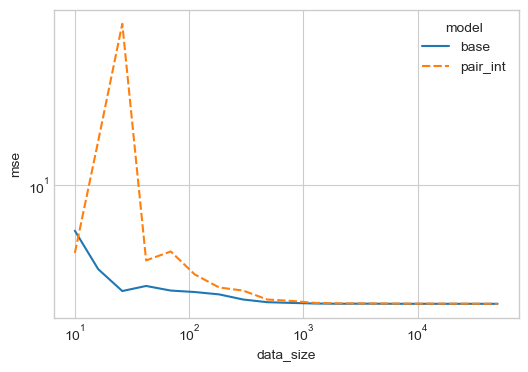

In [7]:
plot_metrics(metrics)

## Simulating multiple datasets

We repeat the above but repeating over multiple random datasets.
This gives us performance on average.

Low interaction effect

100%|██████████| 100/100 [00:06<00:00, 15.97it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


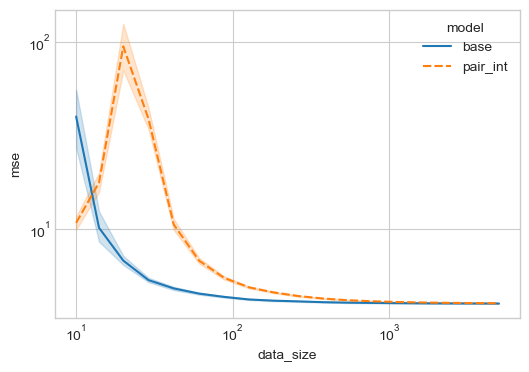

In [15]:
import tqdm

default_models = {"base": predict_model_base, "pair_int": predict_model_pair_int}
def train_loop(models:dict=default_models, gen_data_kwargs:dict=None):
    if gen_data_kwargs is None:
        gen_data_kwargs = {}
    x, y, w, bias, z = gen_data(**gen_data_kwargs)

    n = x.shape[0]
    x_train = x[: n // 2]
    x_test = x[n // 2 :]
    y_train = y[: n // 2]
    y_test = y[n // 2 :]

    y_est = train_models(
        models=models,
        x_train=x_train.to_numpy(),
        y_train=y_train,
        x_test=x_test.to_numpy(),
    )
    _metrics = get_metrics(y_est=y_est, y_test=y_test)
    return _metrics


metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(gen_data_kwargs=dict(n=10_000, x_dim=6, interaction_scale=0.01)))
metrics = pl.concat(metrics)

plot_metrics(metrics)

High interaction effects

Interactions model asymptotically outperforms. But it still under performs at the beginning.

100%|██████████| 100/100 [00:06<00:00, 15.02it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


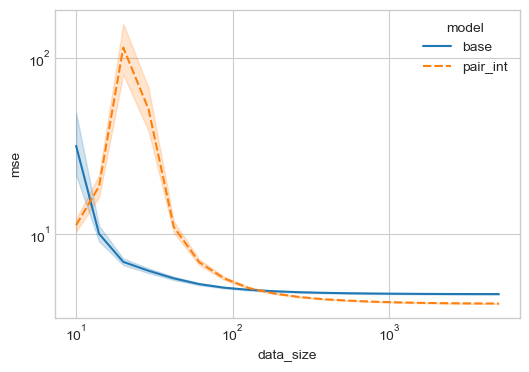

In [16]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(gen_data_kwargs=dict(n=10_000, x_dim=6, interaction_scale=1.0)))
metrics = pl.concat(metrics)

plot_metrics(metrics)

Super High interaction effects

The interactions model still under performs at the beginning, but the asymptotic performance is improved.

In [10]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(gen_data_kwargs=dict(n=10_000, x_dim=6, interaction_scale=3.0)))
metrics = pl.concat(metrics)

plot_metrics(metrics)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by LinearRegression.

We see that the base effects model performs between for smaller amounts of data. This makes sense as there are fewer parameters to learn.
The asymptotic performance of the interactions model is better whenever there are interactions in the data, or at least as good as the base model when interactions are not present.

Can we find models that perform better across all these scenarios?

### Standard regularisation (L1/L2)
It makes sense that regularisation would help here to prevent the poor performance with loss data sizes.

It has asymptotic performance similar to the interactions model but slightly worse.
It does improve performance degradation at small data sizes.

Grid search could be used to optimise this.

In [18]:
def predict_model_elastic_reg(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = sklearn.linear_model.ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=5000)
    _model.fit(x_train, y_train)
    return _model.predict(x_test)


def predict_model_ridge_reg(
    x_train: np.array, y_train: np.array, x_test: np.array, alpha:float=1.0
) -> np.array:
    _model = sklearn.linear_model.Ridge(alpha=alpha)
    _model.fit(x_train, y_train)
    return _model.predict(x_test)


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


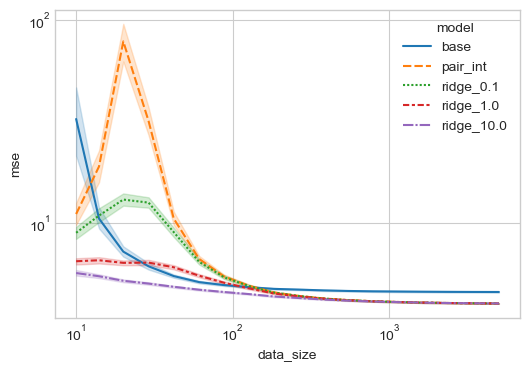

In [19]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(n=10_000,
            x_dim=6,
            interaction_scale=1.0),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                # "elastic": predict_model_elastic_reg,
                "ridge_0.1": lambda *x: predict_model_ridge_reg(*x, alpha=0.1),
                "ridge_1.0": lambda *x: predict_model_ridge_reg(*x, alpha=1.0),
                "ridge_10.0": lambda *x: predict_model_ridge_reg(*x, alpha=10.0),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)

## Bayesian prior based

Ridge regression adds regularisation evenly across all parameters.
It doesn't distinquish between base effects and interactions.

Can we use Bayesian regression to solve this?
We could add priors on each model weight, and treat the interactions with a different prior to the base effects.

How can we add different priors to each weights?
We can adjust the weights covariance matrix for the prior distribution.
We typically use a multi-variate Gaussian distribution over the model weights, with a diagonal covariance matrix.
The standard deviation of these diagonal terms denote the spread of each model weight.
For the interactions we make these terms lower to denote a stronger prior that the interactions should not deviate as much as the base effects.

This should make the model focus training on the base effects, and the interactions will start to deviate more when there is more data available.

The implementation was based a [previous notebook](https://github.com/stanton119/data-analysis/blob/master/SequentialBayesianRegression/sequential_bayesian_linear_regression.ipynb).

In [21]:
class BayesLinearRegressor:
    def __init__(
        self,
        number_of_features,
        mean=None,
        cov=None,
        alpha=1e6,
        beta=1,
        fit_intercept: bool = True,
    ):
        self.fit_intercept = fit_intercept
        self.number_of_features = number_of_features

        if self.fit_intercept:
            self.number_of_features = self.number_of_features + 1

        # prior distribution on weights
        if mean is None:
            self.mean = np.array([[0] * (self.number_of_features)], dtype=float).T

        if cov is None:
            self.cov = alpha * np.identity(self.number_of_features)
        else:
            self.cov = cov
        self.cov_inv = np.linalg.inv(self.cov)
        self.cov_init = self.cov

        self.beta = beta  # process noise

    def fit(self, X, y):
        return self.update(X, y)

    def update(self, X, y, inc_alpha=None):
        """
        Perform a bayesian update step
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if self.fit_intercept:
            X = np.hstack([np.full((X.shape[0], 1), 1), X])
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[:, np.newaxis]
        if X.shape[1] > self.number_of_features:
            X = X[:, : self.number_of_features]

        # update state of covariance and means
        cov_n_inv = self.cov_inv + self.beta * X.T @ X
        cov_n = np.linalg.inv(cov_n_inv)
        mean_n = cov_n @ (self.cov_inv @ self.mean + self.beta * X.T @ y)

        if inc_alpha is not None:
            # cov_n = cov_n - (cov_n - self.cov_init) * inc_alpha
            cov_n = cov_n + inc_alpha * np.identity(self.number_of_features)

            cov_n_inv = np.linalg.inv(cov_n)

        self.cov_inv = cov_n_inv
        self.cov = cov_n
        self.mean = mean_n

    def predict(self, X, return_std: bool = False) -> [np.array, np.array]:
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if self.fit_intercept:
            X = np.hstack([np.full((X.shape[0], 1), 1), X])
        if X.shape[1] > self.number_of_features:
            X = X[:, : self.number_of_features]

        mean = X @ self.mean
        if not return_std:
            return mean

        if X.shape[0] < 1_000:
            scale = np.sqrt(np.sum(X @ self.cov @ X.T, axis=1))
        else:
            scale = None
        return mean, scale

    @property
    def coef_(self):
        return self.mean.flatten()

    @property
    def scale_(self):
        return np.sqrt(np.diag(self.cov))

    @staticmethod
    def callback(model) -> dict:
        return {"coef": model.coef_, "scale": model.scale_}


def cov_split_base_int(
    n_base: int,
    n_int: int,
    alpha_base: float = 1e6,
    alpha_int: float = 1e3,
    fit_intercept: bool = True,
) -> np.array:
    fit_intercept = int(fit_intercept)
    cov = np.identity(fit_intercept + n_base + n_int)
    cov[fit_intercept : n_base + fit_intercept] = (
        cov[fit_intercept : n_base + fit_intercept] * alpha_base
    )
    cov[n_base + fit_intercept :] = cov[n_base + fit_intercept :] * alpha_int
    return cov

def predict_model_bayes(
    x_train: np.array, y_train: np.array, x_test: np.array, alpha_base=1e6, alpha_int=1e6
) -> np.array:
    cov = cov_split_base_int(n_base=x_dim, n_int=x_train.shape[1]-x_dim, alpha_base=alpha_base, alpha_int=alpha_int)
    _model = BayesLinearRegressor(number_of_features=x_train.shape[1], cov=cov)
    _model.fit(x_train, y_train)
    return _model.predict(x_test)

Using the same uninformed prior for everything gives the same performance as the normal linear regression with the interaction effects.

100%|██████████| 100/100 [00:31<00:00,  3.14it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


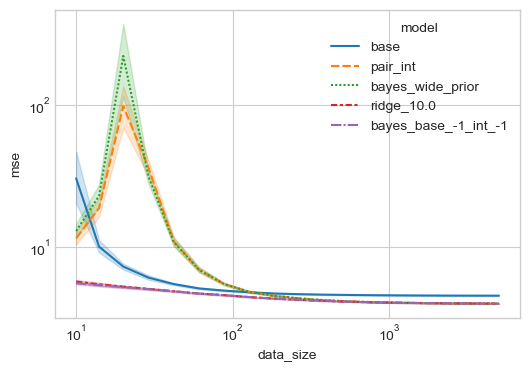

In [22]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(n=10_000,
            x_dim=6,
            interaction_scale=1.0),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "bayes_wide_prior": predict_model_bayes,
                "ridge_10.0": lambda *x: predict_model_ridge_reg(*x, alpha=10.0),
                "bayes_base_-1_int_-1": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e-1),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)

We can see that the Bayesian regression is similar to the interactions model when uninformed priors are used for the weights.
We also see that ridge regression is equivalent to Bayesian regression with a strong prior which is equal between base and interaction effects.

However the benefit of the Bayesian regression is that we can have stronger priors for the interaction terms only.
All the other models can be represented as a subset of the Bayesian regression model.

For example a very strong prior on the interactions is similar to the base model:

100%|██████████| 100/100 [00:06<00:00, 16.18it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_38828/285701580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


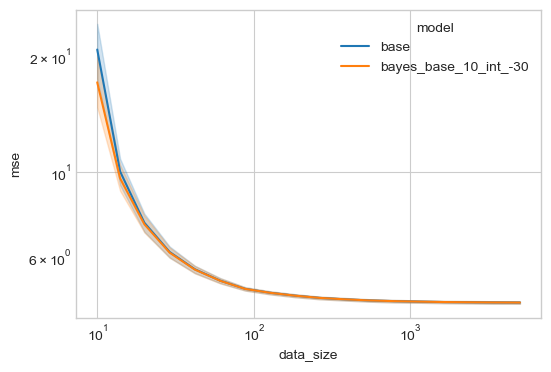

In [ ]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(n=10_000,
            x_dim=6,
            interaction_scale=1.0),
            models={
                "base": predict_model_base,
                "bayes_base_10_int_-30": lambda *x: predict_model_bayes(*x, alpha_base=1e10, alpha_int=1e-30),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)

### How to find the optimal priors?

Can we beat ridge regression? What scenarios is ridge regression not sufficient?

Lets plot some scenarios between ridge as Bayesian regression with a higher interaction regularisation

Low interaction effect

Should need high regularisation on the interactions only here

100%|██████████| 100/100 [00:12<00:00,  8.23it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_38828/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


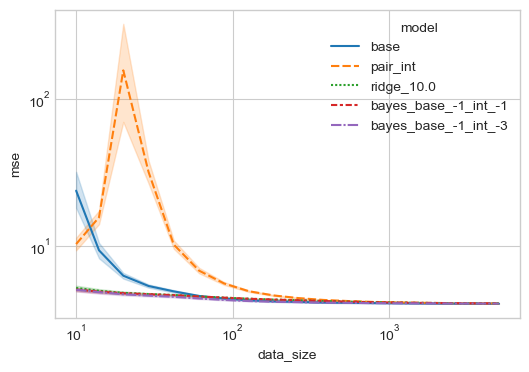

In [ ]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(n=10_000,
            x_dim=6,
            interaction_scale=0.0),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "ridge_10.0": lambda *x: predict_model_ridge_reg(*x, alpha=10.0),
                "bayes_base_-1_int_-1": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e-1),
                "bayes_base_-1_int_-3": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e-3),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)

Medium interaction effect

100%|██████████| 100/100 [00:16<00:00,  6.21it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_38828/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


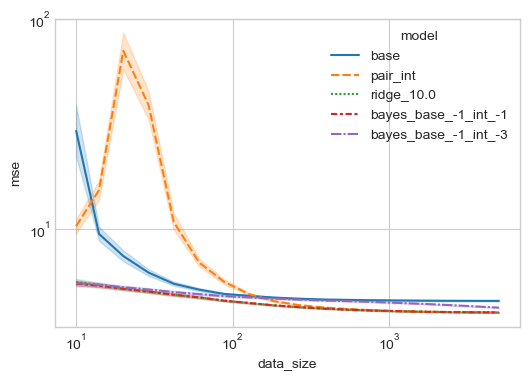

In [ ]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(n=10_000,
            x_dim=6,
            interaction_scale=1.0),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "ridge_10.0": lambda *x: predict_model_ridge_reg(*x, alpha=10.0),
                "bayes_base_-1_int_-1": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e-1),
                "bayes_base_-1_int_-3": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e-3),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)

High interaction effect

We want lower regularisation on the interactions here to prevent degrading asymptotic performance.

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_38828/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


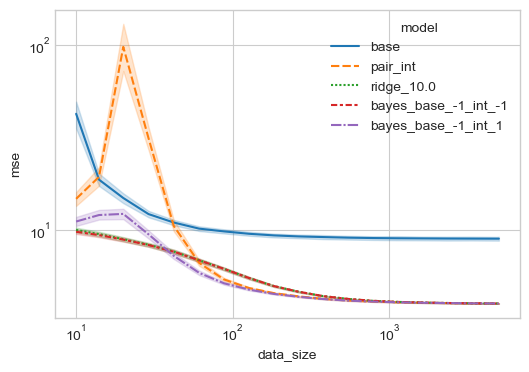

In [ ]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(n=10_000,
            x_dim=6,
            interaction_scale=3.0),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "ridge_10.0": lambda *x: predict_model_ridge_reg(*x, alpha=10.0),
                "bayes_base_-1_int_-1": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e-1),
                "bayes_base_-1_int_1": lambda *x: predict_model_bayes(*x, alpha_base=1e-1, alpha_int=1e1),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)

# TODO

* Partial fit the models to speed up training
* Test each iteration
* Compare partial fit on SGD regressors to bayesian updates and full data fits
* Measure as 'cumulative regret'
* Check model coefficients are learning something reasonable
* Test scenarios with more/less noise so less regularisation is require


Model options
* Fit base effects model, use coefficients as priors in an interaction model
* Interactions model with tight priors on interaction terms
  * Use the bayesian model to have different priors - scale the covariance matrix accordingly
  * Use MCMC
* Pytorch to apply L2 regularisation to half the weights
  * Example notebook - https://github.com/stanton119/data-analysis/blob/master/PyTorchStuff/elastic_net/elastic_linear.ipynb

Scenario testing:

* Low noise (0.5) = base model still the best, too much regularisation on base effects?
* Low noise, low interactions = base model still the best, too much regularisation on base effects?
  * less base regularised + high interaction regularisation = good

100%|██████████| 100/100 [00:17<00:00,  5.87it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


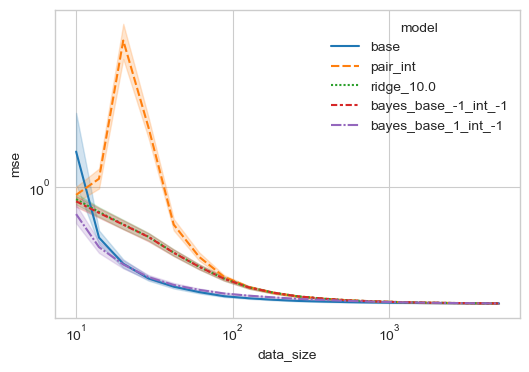

In [25]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(
                n=10_000, x_dim=6, interaction_scale=0.05, noise_level=0.5
            ),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "bayes_base_-1_int_-1": lambda *x: predict_model_bayes(
                    *x, alpha_base=1e-1, alpha_int=1e-1
                ),
                "bayes_base_1_int_-1": lambda *x: predict_model_bayes(
                    *x, alpha_base=1e1, alpha_int=1e-1
                ),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48694/1525875327.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


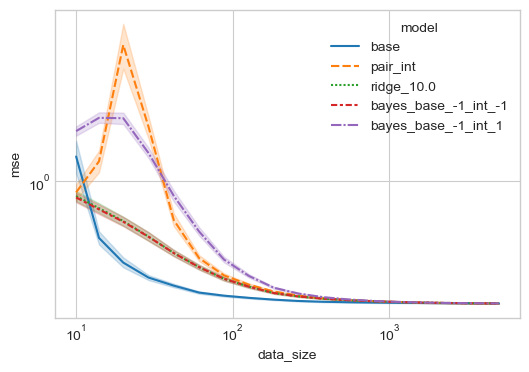

In [ ]:
metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            gen_data_kwargs=dict(
                n=10_000, x_dim=6, interaction_scale=0.05, noise_level=0.5
            ),
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "ridge_10.0": lambda *x: predict_model_ridge_reg(*x, alpha=10.0),
                "bayes_base_-1_int_-1": lambda *x: predict_model_bayes(
                    *x, alpha_base=1e-1, alpha_int=1e-1
                ),
                "bayes_base_-1_int_1": lambda *x: predict_model_bayes(
                    *x, alpha_base=1e-1, alpha_int=1e1
                ),
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)


In [ ]:
import numpy as np
import sklearn.preprocessing

RND = np.random.default_rng(0)


def gen_data(
    n: int = 100_000,
    x_dim: int = 6,
    noise_level: float = 2.0,
    interaction_scale: float = 0.01,
):
    # base features
    x_base = pd.DataFrame(RND.uniform(-1, 1, size=(n, x_dim)))

    # add interactions
    int_trans = sklearn.preprocessing.PolynomialFeatures(
        interaction_only=True, degree=2, include_bias=False
    ).set_output(transform="pandas")
    x = int_trans.fit_transform(x_base)

    # make weights
    bias = RND.uniform(-1, 1, size=(1))
    w = RND.uniform(-1, 1, size=(x.shape[1]))
    # scale interaction weights
    w[x_dim:] = interaction_scale * w[x_dim:]

    # make outcomes
    z = np.dot(x, w)
    y = bias + z + noise_level * RND.normal(size=(n))

    return x, y, w, bias, z


n = 100_000
x_dim = 6
x, y, w, bias, z = gen_data(n=n, x_dim=x_dim)


## Specifing priors
How do we specify the interaction priors as a function of the interaction level?

* Can we learn this as a hyper prior we train at the same time?
* Function of the training size?
* Within bandits - function of performance? If we have converged then increase complexity?

# Appendix

### Statsmodel sanity check

Using statsmodels gives the same answer to our sklearn approach.

100%|██████████| 100/100 [00:15<00:00,  6.42it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_38828/285701580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


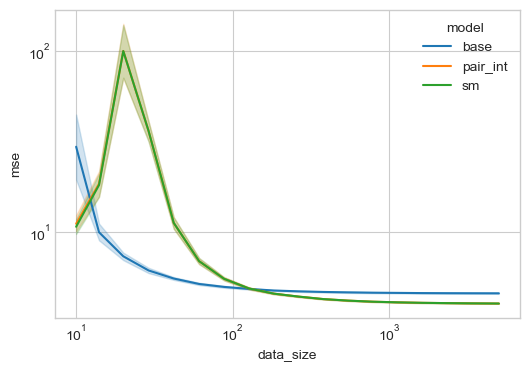

In [ ]:
import statsmodels.api as sm


def predict_model_sm(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = sm.OLS(y_train, sm.add_constant(x_train))
    _res = _model.fit()
    return _res.predict(sm.add_constant(x_test))
    

metrics = []
for _i in tqdm.trange(100):
    metrics.append(
        train_loop(
            n=10_000,
            x_dim=6,
            interaction_scale=1.0,
            models={
                "base": predict_model_base,
                "pair_int": predict_model_pair_int,
                "sm": predict_model_sm,
            },
        )
    )
metrics = pl.concat(metrics)

plot_metrics(metrics)